In [ ]:
import gymnasium as gym
import numpy as np
import d3rlpy
import pickle

import matplotlib.pyplot as plt
from env.atari.represented_atari_game import GymCompatWrapper2
from online_main import OneHotWrapper

hyperparams = {
        "env": "FrozenLake-v1", #"CartPole-v0", # "Acrobot-v0", "MountainCar-v0", "FrozenLake-v1", "CliffWalking-v0", "Taxi-v3", "RepresentedPong-v0"
        "seed": 42069,
        "n_episodes": 100,#5000,
        "max_episode_len": 200, # Around 10h per 100k steps in Leviathan server
        "eps": 0.1,  # epsilon for exploration
        "n_exp": 5,
        "n_pretrain_eps": 30,
        "n_online_eps": 170, #10-290 for mountainCar, 30-170 for CartPole
        "gpu": True, # True if use GPU to train with d3rlpy
        "buffer_size": 100000, #Test with 100k, 200k, 500k. 1M might be too much
        "data_path": None,#'data/CartPole_Qwen2.5-7B-Instruct_Neps_10_20250406040150.pkl',
        "model_path": None,#'d3rlpy_loss/DoubleDQN_online_20250331153346/model_600000.d3',
        "batch_size":256, #Test smaller batch size: 32, 64. May be noisier
        "learning_rate":5e-5,
        "gamma":0.99,
        "target_update_interval":1000 #Test with 1k, 2k, 5k
    }

if "Represented" in hyperparams["env"]:
    env = GymCompatWrapper2(gym.make(hyperparams["env"]))
    eval_env = GymCompatWrapper2(gym.make(hyperparams["env"]))
elif isinstance(gym.make(hyperparams["env"]).observation_space, gym.spaces.Discrete):
    env = OneHotWrapper(gym.make(hyperparams["env"]))
    eval_env = OneHotWrapper(gym.make(hyperparams["env"]))
else:
    env = gym.make(hyperparams["env"])
    eval_env = gym.make(hyperparams["env"])

# fix seed
d3rlpy.seed(hyperparams["seed"])
d3rlpy.envs.seed_env(env, hyperparams["seed"])
d3rlpy.envs.seed_env(eval_env, hyperparams["seed"])

2025-04-15 18:04.59 [info     ] Register Shimmy environments. 


/home/thangduong/miniconda3/envs/llamagym/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Test online training a new env

In [ ]:
from online_main import online_training

hyperparams = {
        "env": "CliffWalking-v0", #"CartPole-v0", # "Acrobot-v0", "MountainCar-v0", "FrozenLake-v1", Pendulum-v1, "CliffWalking-v0", "Taxi-v3", "RepresentedPong-v0"
        "seed": 42069,
        # "n_episodes": 200,#5000,
        "max_episode_len": 200, # Around 10h per 100k steps in Leviathan server
        "eps": 0.1,  # epsilon for exploration
        "n_exp": 1,
        "n_pretrain_eps": 10,
        "n_online_eps": 190, #10-290 for mountainCar, 30-170 for CartPole
        "gpu": True, # True if use GPU to train with d3rlpy
        "buffer_size": 100000, #Test with 100k, 200k, 500k. 1M might be too much
        "data_path": None,#'data/CartPole_Qwen2.5-7B-Instruct_Neps_10_20250406040150.pkl',
        "model_path": None,#'d3rlpy_loss/DoubleDQN_online_20250331153346/model_600000.d3',
        "batch_size":256, #Test smaller batch size: 32, 64. May be noisier
        "learning_rate":5e-5,
        "gamma":0.99,
        "target_update_interval":1000 #Test with 1k, 2k, 5k
    }

if "Represented" in hyperparams["env"]:
    env = GymCompatWrapper2(gym.make(hyperparams["env"]))
    eval_env = GymCompatWrapper2(gym.make(hyperparams["env"]))
elif isinstance(gym.make(hyperparams["env"]).observation_space, gym.spaces.Discrete):
    env = OneHotWrapper(gym.make(hyperparams["env"]))
    eval_env = OneHotWrapper(gym.make(hyperparams["env"]))
else:
    env = gym.make(hyperparams["env"], max_episode_steps=200)
    eval_env = gym.make(hyperparams["env"], max_episode_steps=200)

# fix seed
d3rlpy.seed(hyperparams["seed"])
d3rlpy.envs.seed_env(env, hyperparams["seed"])
d3rlpy.envs.seed_env(eval_env, hyperparams["seed"])

# explorer = d3rlpy.algos.ConstantEpsilonGreedy(hyperparams['eps'])
explorer = d3rlpy.algos.LinearDecayEpsilonGreedy(
    start_epsilon=1,
    end_epsilon=0.1,
    duration=5000,
)
print(env.observation_space)
out = online_training(env, eval_env, hyperparams, explorer)

Box(0.0, 1.0, (48,), float32)
2025-04-15 18:12.31 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(48,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-04-15 18:12.31 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-04-15 18:12.31 [info     ] Action size has been automatically determined. action_size=4
Empty buffer (just Online training)!


  0%|          | 0/300 [00:00<?, ?it/s]

2025-04-15 18:12.31 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181231
2025-04-15 18:12.31 [debug    ] Building model...             


2025-04-15 18:12.31 [debug    ] Model has been built.         
2025-04-15 18:12.31 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  0%|          | 1/300 [00:01<06:20,  1.27s/it]

2025-04-15 18:12.32 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181232
2025-04-15 18:12.32 [warning  ] Skip building models since they're already built.
2025-04-15 18:12.32 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  1%|          | 2/300 [00:03<08:21,  1.68s/it]

2025-04-15 18:12.34 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181234
2025-04-15 18:12.34 [warning  ] Skip building models since they're already built.
2025-04-15 18:12.34 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  1%|          | 3/300 [00:05<09:45,  1.97s/it]

2025-04-15 18:12.37 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181237
2025-04-15 18:12.37 [warning  ] Skip building models since they're already built.
2025-04-15 18:12.37 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  1%|▏         | 4/300 [00:07<10:34,  2.14s/it]

2025-04-15 18:12.39 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181239
2025-04-15 18:12.39 [warning  ] Skip building models since they're already built.
2025-04-15 18:12.39 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  2%|▏         | 5/300 [00:10<10:55,  2.22s/it]

2025-04-15 18:12.41 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181241
2025-04-15 18:12.41 [warning  ] Skip building models since they're already built.
2025-04-15 18:12.41 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  2%|▏         | 6/300 [00:12<10:55,  2.23s/it]

2025-04-15 18:12.44 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181244
2025-04-15 18:12.44 [warning  ] Skip building models since they're already built.
2025-04-15 18:12.44 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  2%|▏         | 7/300 [00:14<11:00,  2.25s/it]

2025-04-15 18:12.46 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181246
2025-04-15 18:12.46 [warning  ] Skip building models since they're already built.
2025-04-15 18:12.46 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  3%|▎         | 8/300 [00:17<11:14,  2.31s/it]

2025-04-15 18:12.48 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181248
2025-04-15 18:12.48 [warning  ] Skip building models since they're already built.
2025-04-15 18:12.48 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  3%|▎         | 9/300 [00:19<11:22,  2.34s/it]

2025-04-15 18:12.51 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181251
2025-04-15 18:12.51 [warning  ] Skip building models since they're already built.
2025-04-15 18:12.51 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  3%|▎         | 10/300 [00:22<11:28,  2.38s/it]

2025-04-15 18:12.53 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181253
2025-04-15 18:12.53 [warning  ] Skip building models since they're already built.
2025-04-15 18:12.53 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  4%|▎         | 11/300 [00:24<11:26,  2.38s/it]

2025-04-15 18:12.56 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181256
2025-04-15 18:12.56 [warning  ] Skip building models since they're already built.
2025-04-15 18:12.56 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  4%|▍         | 12/300 [00:26<11:23,  2.37s/it]

2025-04-15 18:12.58 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181258
2025-04-15 18:12.58 [warning  ] Skip building models since they're already built.
2025-04-15 18:12.58 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  4%|▍         | 13/300 [00:29<11:23,  2.38s/it]

2025-04-15 18:13.00 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181300
2025-04-15 18:13.00 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.00 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  5%|▍         | 14/300 [00:31<11:18,  2.37s/it]

2025-04-15 18:13.03 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181303
2025-04-15 18:13.03 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.03 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  5%|▌         | 15/300 [00:34<11:16,  2.37s/it]

2025-04-15 18:13.05 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181305
2025-04-15 18:13.05 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.05 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  5%|▌         | 16/300 [00:36<11:11,  2.37s/it]

2025-04-15 18:13.08 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181308
2025-04-15 18:13.08 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.08 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  6%|▌         | 17/300 [00:38<11:12,  2.38s/it]

2025-04-15 18:13.10 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181310
2025-04-15 18:13.10 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.10 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  6%|▌         | 18/300 [00:41<11:10,  2.38s/it]

2025-04-15 18:13.12 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181312
2025-04-15 18:13.12 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.12 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  6%|▋         | 19/300 [00:43<11:16,  2.41s/it]

2025-04-15 18:13.15 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181315
2025-04-15 18:13.15 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.15 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  7%|▋         | 20/300 [00:46<11:11,  2.40s/it]

2025-04-15 18:13.17 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181317
2025-04-15 18:13.17 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.17 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  7%|▋         | 21/300 [00:48<11:07,  2.39s/it]

2025-04-15 18:13.20 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181320
2025-04-15 18:13.20 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.20 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  7%|▋         | 22/300 [00:50<11:07,  2.40s/it]

2025-04-15 18:13.22 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181322
2025-04-15 18:13.22 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.22 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  8%|▊         | 23/300 [00:53<11:01,  2.39s/it]

2025-04-15 18:13.24 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181324
2025-04-15 18:13.24 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.24 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  8%|▊         | 24/300 [00:55<10:59,  2.39s/it]

2025-04-15 18:13.27 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181327
2025-04-15 18:13.27 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.27 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  8%|▊         | 25/300 [00:57<10:52,  2.37s/it]

2025-04-15 18:13.29 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181329
2025-04-15 18:13.29 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.29 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  9%|▊         | 26/300 [01:00<10:53,  2.39s/it]

2025-04-15 18:13.31 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181331
2025-04-15 18:13.31 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.31 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  9%|▉         | 27/300 [01:02<10:55,  2.40s/it]

2025-04-15 18:13.34 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181334
2025-04-15 18:13.34 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.34 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


  9%|▉         | 28/300 [01:05<10:55,  2.41s/it]

2025-04-15 18:13.36 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181336
2025-04-15 18:13.36 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.36 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 10%|▉         | 29/300 [01:07<10:55,  2.42s/it]

2025-04-15 18:13.39 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181339
2025-04-15 18:13.39 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.39 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 10%|█         | 30/300 [01:10<10:54,  2.43s/it]

2025-04-15 18:13.41 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181341
2025-04-15 18:13.41 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.41 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 10%|█         | 31/300 [01:12<10:51,  2.42s/it]

2025-04-15 18:13.44 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181344
2025-04-15 18:13.44 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.44 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 11%|█         | 32/300 [01:15<10:56,  2.45s/it]

2025-04-15 18:13.46 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181346
2025-04-15 18:13.46 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.46 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 11%|█         | 33/300 [01:17<11:06,  2.50s/it]

2025-04-15 18:13.49 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181349
2025-04-15 18:13.49 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.49 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 11%|█▏        | 34/300 [01:20<11:07,  2.51s/it]

2025-04-15 18:13.51 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181351
2025-04-15 18:13.51 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.51 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 12%|█▏        | 35/300 [01:22<11:02,  2.50s/it]

2025-04-15 18:13.54 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181354
2025-04-15 18:13.54 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.54 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 12%|█▏        | 36/300 [01:25<10:56,  2.49s/it]

2025-04-15 18:13.56 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181356
2025-04-15 18:13.56 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.56 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 12%|█▏        | 37/300 [01:27<10:44,  2.45s/it]

2025-04-15 18:13.59 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181359
2025-04-15 18:13.59 [warning  ] Skip building models since they're already built.
2025-04-15 18:13.59 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 13%|█▎        | 38/300 [01:29<10:37,  2.43s/it]

2025-04-15 18:14.01 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181401
2025-04-15 18:14.01 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.01 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 13%|█▎        | 39/300 [01:32<10:28,  2.41s/it]

2025-04-15 18:14.03 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181403
2025-04-15 18:14.03 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.03 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 13%|█▎        | 40/300 [01:34<10:30,  2.42s/it]

2025-04-15 18:14.06 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181406
2025-04-15 18:14.06 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.06 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 14%|█▎        | 41/300 [01:37<10:27,  2.42s/it]

2025-04-15 18:14.08 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181408
2025-04-15 18:14.08 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.08 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 14%|█▍        | 42/300 [01:39<10:29,  2.44s/it]

2025-04-15 18:14.11 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181411
2025-04-15 18:14.11 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.11 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 14%|█▍        | 43/300 [01:41<10:26,  2.44s/it]

2025-04-15 18:14.13 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181413
2025-04-15 18:14.13 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.13 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 15%|█▍        | 44/300 [01:44<10:22,  2.43s/it]

2025-04-15 18:14.16 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181416
2025-04-15 18:14.16 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.16 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 15%|█▌        | 45/300 [01:46<10:24,  2.45s/it]

2025-04-15 18:14.18 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181418
2025-04-15 18:14.18 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.18 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 15%|█▌        | 46/300 [01:49<10:19,  2.44s/it]

2025-04-15 18:14.20 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181420
2025-04-15 18:14.20 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.20 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 16%|█▌        | 47/300 [01:51<10:16,  2.44s/it]

2025-04-15 18:14.23 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181423
2025-04-15 18:14.23 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.23 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 16%|█▌        | 48/300 [01:54<10:09,  2.42s/it]

2025-04-15 18:14.25 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181425
2025-04-15 18:14.25 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.25 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 16%|█▋        | 49/300 [01:56<10:02,  2.40s/it]

2025-04-15 18:14.28 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181428
2025-04-15 18:14.28 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.28 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 17%|█▋        | 50/300 [01:58<09:58,  2.40s/it]

2025-04-15 18:14.30 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181430
2025-04-15 18:14.30 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.30 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 17%|█▋        | 51/300 [02:01<10:00,  2.41s/it]

2025-04-15 18:14.32 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181432
2025-04-15 18:14.32 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.32 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 17%|█▋        | 52/300 [02:03<09:58,  2.41s/it]

2025-04-15 18:14.35 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181435
2025-04-15 18:14.35 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.35 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 18%|█▊        | 53/300 [02:06<09:52,  2.40s/it]

2025-04-15 18:14.37 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181437
2025-04-15 18:14.37 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.37 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 18%|█▊        | 54/300 [02:08<09:50,  2.40s/it]

2025-04-15 18:14.40 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181440
2025-04-15 18:14.40 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.40 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 18%|█▊        | 55/300 [02:10<09:54,  2.43s/it]

2025-04-15 18:14.42 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181442
2025-04-15 18:14.42 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.42 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 19%|█▊        | 56/300 [02:13<09:52,  2.43s/it]

2025-04-15 18:14.45 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181445
2025-04-15 18:14.45 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.45 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 19%|█▉        | 57/300 [02:15<09:48,  2.42s/it]

2025-04-15 18:14.47 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181447
2025-04-15 18:14.47 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.47 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 19%|█▉        | 58/300 [02:18<09:41,  2.40s/it]

2025-04-15 18:14.49 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181449
2025-04-15 18:14.49 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.49 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 20%|█▉        | 59/300 [02:20<09:46,  2.43s/it]

2025-04-15 18:14.52 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181452
2025-04-15 18:14.52 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.52 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 20%|██        | 60/300 [02:23<09:45,  2.44s/it]

2025-04-15 18:14.54 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181454
2025-04-15 18:14.54 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.54 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 20%|██        | 61/300 [02:25<09:37,  2.42s/it]

2025-04-15 18:14.57 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181457
2025-04-15 18:14.57 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.57 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 21%|██        | 62/300 [02:27<09:31,  2.40s/it]

2025-04-15 18:14.59 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181459
2025-04-15 18:14.59 [warning  ] Skip building models since they're already built.
2025-04-15 18:14.59 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 21%|██        | 63/300 [02:30<09:26,  2.39s/it]

2025-04-15 18:15.01 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181501
2025-04-15 18:15.01 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.01 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 21%|██▏       | 64/300 [02:32<09:28,  2.41s/it]

2025-04-15 18:15.04 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181504
2025-04-15 18:15.04 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.04 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 22%|██▏       | 65/300 [02:35<09:31,  2.43s/it]

2025-04-15 18:15.06 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181506
2025-04-15 18:15.06 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.06 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 22%|██▏       | 66/300 [02:37<09:26,  2.42s/it]

2025-04-15 18:15.09 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181509
2025-04-15 18:15.09 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.09 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 22%|██▏       | 67/300 [02:39<09:19,  2.40s/it]

2025-04-15 18:15.11 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181511
2025-04-15 18:15.11 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.11 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 23%|██▎       | 68/300 [02:42<09:12,  2.38s/it]

2025-04-15 18:15.13 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181513
2025-04-15 18:15.13 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.13 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 23%|██▎       | 69/300 [02:44<09:19,  2.42s/it]

2025-04-15 18:15.16 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181516
2025-04-15 18:15.16 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.16 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 23%|██▎       | 70/300 [02:47<09:07,  2.38s/it]

2025-04-15 18:15.18 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181518
2025-04-15 18:15.18 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.18 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 24%|██▎       | 71/300 [02:49<09:27,  2.48s/it]

2025-04-15 18:15.21 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181521
2025-04-15 18:15.21 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.21 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 24%|██▍       | 72/300 [02:52<09:26,  2.48s/it]

2025-04-15 18:15.23 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181523
2025-04-15 18:15.23 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.23 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 24%|██▍       | 73/300 [02:54<09:29,  2.51s/it]

2025-04-15 18:15.26 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181526
2025-04-15 18:15.26 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.26 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 25%|██▍       | 74/300 [02:57<09:38,  2.56s/it]

2025-04-15 18:15.29 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181529
2025-04-15 18:15.29 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.29 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 25%|██▌       | 75/300 [03:00<09:36,  2.56s/it]

2025-04-15 18:15.31 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181531
2025-04-15 18:15.31 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.31 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 25%|██▌       | 76/300 [03:02<09:26,  2.53s/it]

2025-04-15 18:15.34 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181534
2025-04-15 18:15.34 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.34 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 26%|██▌       | 77/300 [03:04<09:16,  2.49s/it]

2025-04-15 18:15.36 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181536
2025-04-15 18:15.36 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.36 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 26%|██▌       | 78/300 [03:07<09:06,  2.46s/it]

2025-04-15 18:15.38 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181538
2025-04-15 18:15.38 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.38 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 26%|██▋       | 79/300 [03:09<09:00,  2.44s/it]

2025-04-15 18:15.41 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181541
2025-04-15 18:15.41 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.41 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 27%|██▋       | 80/300 [03:12<08:55,  2.43s/it]

2025-04-15 18:15.43 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181543
2025-04-15 18:15.43 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.43 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 27%|██▋       | 81/300 [03:14<08:51,  2.43s/it]

2025-04-15 18:15.46 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181546
2025-04-15 18:15.46 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.46 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 27%|██▋       | 82/300 [03:17<09:00,  2.48s/it]

2025-04-15 18:15.48 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181548
2025-04-15 18:15.48 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.48 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 28%|██▊       | 83/300 [03:19<08:53,  2.46s/it]

2025-04-15 18:15.51 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181551
2025-04-15 18:15.51 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.51 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 28%|██▊       | 84/300 [03:21<08:48,  2.45s/it]

2025-04-15 18:15.53 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181553
2025-04-15 18:15.53 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.53 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 28%|██▊       | 85/300 [03:24<08:40,  2.42s/it]

2025-04-15 18:15.55 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181555
2025-04-15 18:15.55 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.55 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 29%|██▊       | 86/300 [03:26<08:37,  2.42s/it]

2025-04-15 18:15.58 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181558
2025-04-15 18:15.58 [warning  ] Skip building models since they're already built.
2025-04-15 18:15.58 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 29%|██▉       | 87/300 [03:29<08:36,  2.43s/it]

2025-04-15 18:16.00 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181600
2025-04-15 18:16.00 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.00 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 29%|██▉       | 88/300 [03:31<08:34,  2.43s/it]

2025-04-15 18:16.03 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181603
2025-04-15 18:16.03 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.03 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 30%|██▉       | 89/300 [03:34<08:30,  2.42s/it]

2025-04-15 18:16.05 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181605
2025-04-15 18:16.05 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.05 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 30%|███       | 90/300 [03:36<08:30,  2.43s/it]

2025-04-15 18:16.08 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181608
2025-04-15 18:16.08 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.08 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 30%|███       | 91/300 [03:38<08:29,  2.44s/it]

2025-04-15 18:16.10 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181610
2025-04-15 18:16.10 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.10 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 31%|███       | 92/300 [03:41<08:27,  2.44s/it]

2025-04-15 18:16.13 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181613
2025-04-15 18:16.13 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.13 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 31%|███       | 93/300 [03:43<08:25,  2.44s/it]

2025-04-15 18:16.15 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181615
2025-04-15 18:16.15 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.15 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 31%|███▏      | 94/300 [03:46<08:17,  2.42s/it]

2025-04-15 18:16.17 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181617
2025-04-15 18:16.17 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.17 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 32%|███▏      | 95/300 [03:48<08:14,  2.41s/it]

2025-04-15 18:16.20 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181620
2025-04-15 18:16.20 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.20 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 32%|███▏      | 96/300 [03:51<08:13,  2.42s/it]

2025-04-15 18:16.22 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181622
2025-04-15 18:16.22 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.22 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 32%|███▏      | 97/300 [03:53<08:13,  2.43s/it]

2025-04-15 18:16.25 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181625
2025-04-15 18:16.25 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.25 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 33%|███▎      | 98/300 [03:55<08:11,  2.43s/it]

2025-04-15 18:16.27 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181627
2025-04-15 18:16.27 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.27 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 33%|███▎      | 99/300 [03:58<08:09,  2.44s/it]

2025-04-15 18:16.30 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181630
2025-04-15 18:16.30 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.30 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 33%|███▎      | 100/300 [04:00<08:06,  2.43s/it]

2025-04-15 18:16.32 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181632
2025-04-15 18:16.32 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.32 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 34%|███▎      | 101/300 [04:03<08:04,  2.44s/it]

2025-04-15 18:16.34 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181634
2025-04-15 18:16.34 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.34 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 34%|███▍      | 102/300 [04:05<08:04,  2.45s/it]

2025-04-15 18:16.37 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181637
2025-04-15 18:16.37 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.37 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 34%|███▍      | 103/300 [04:08<07:59,  2.43s/it]

2025-04-15 18:16.39 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181639
2025-04-15 18:16.39 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.39 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 35%|███▍      | 104/300 [04:10<07:55,  2.43s/it]

2025-04-15 18:16.42 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181642
2025-04-15 18:16.42 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.42 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 35%|███▌      | 105/300 [04:12<07:52,  2.42s/it]

2025-04-15 18:16.44 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181644
2025-04-15 18:16.44 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.44 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 35%|███▌      | 106/300 [04:15<07:54,  2.45s/it]

2025-04-15 18:16.47 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181647
2025-04-15 18:16.47 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.47 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 36%|███▌      | 107/300 [04:17<07:49,  2.43s/it]

2025-04-15 18:16.49 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181649
2025-04-15 18:16.49 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.49 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 36%|███▌      | 108/300 [04:20<07:47,  2.43s/it]

2025-04-15 18:16.51 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181651
2025-04-15 18:16.51 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.51 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 36%|███▋      | 109/300 [04:22<07:46,  2.44s/it]

2025-04-15 18:16.54 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181654
2025-04-15 18:16.54 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.54 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 37%|███▋      | 110/300 [04:25<07:43,  2.44s/it]

2025-04-15 18:16.56 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181656
2025-04-15 18:16.56 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.56 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 37%|███▋      | 111/300 [04:27<07:43,  2.45s/it]

2025-04-15 18:16.59 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181659
2025-04-15 18:16.59 [warning  ] Skip building models since they're already built.
2025-04-15 18:16.59 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 37%|███▋      | 112/300 [04:30<07:41,  2.46s/it]

2025-04-15 18:17.01 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181701
2025-04-15 18:17.01 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.01 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 38%|███▊      | 113/300 [04:32<07:41,  2.47s/it]

2025-04-15 18:17.04 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181704
2025-04-15 18:17.04 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.04 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 38%|███▊      | 114/300 [04:35<07:37,  2.46s/it]

2025-04-15 18:17.06 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181706
2025-04-15 18:17.06 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.06 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 38%|███▊      | 115/300 [04:37<07:35,  2.46s/it]

2025-04-15 18:17.09 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181709
2025-04-15 18:17.09 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.09 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 39%|███▊      | 116/300 [04:39<07:32,  2.46s/it]

2025-04-15 18:17.11 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181711
2025-04-15 18:17.11 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.11 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 39%|███▉      | 117/300 [04:42<07:30,  2.46s/it]

2025-04-15 18:17.14 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181714
2025-04-15 18:17.14 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.14 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 39%|███▉      | 118/300 [04:44<07:27,  2.46s/it]

2025-04-15 18:17.16 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181716
2025-04-15 18:17.16 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.16 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 40%|███▉      | 119/300 [04:47<07:21,  2.44s/it]

2025-04-15 18:17.18 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181718
2025-04-15 18:17.18 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.18 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 40%|████      | 120/300 [04:49<07:21,  2.45s/it]

2025-04-15 18:17.21 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181721
2025-04-15 18:17.21 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.21 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 40%|████      | 121/300 [04:52<07:20,  2.46s/it]

2025-04-15 18:17.23 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181723
2025-04-15 18:17.23 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.23 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 41%|████      | 122/300 [04:54<07:19,  2.47s/it]

2025-04-15 18:17.26 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181726
2025-04-15 18:17.26 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.26 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 41%|████      | 123/300 [04:57<07:14,  2.45s/it]

2025-04-15 18:17.28 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181728
2025-04-15 18:17.28 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.28 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 41%|████▏     | 124/300 [04:59<07:14,  2.47s/it]

2025-04-15 18:17.31 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181731
2025-04-15 18:17.31 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.31 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 42%|████▏     | 125/300 [05:02<07:07,  2.45s/it]

2025-04-15 18:17.33 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181733
2025-04-15 18:17.33 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.33 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 42%|████▏     | 126/300 [05:04<07:06,  2.45s/it]

2025-04-15 18:17.36 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181736
2025-04-15 18:17.36 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.36 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 42%|████▏     | 127/300 [05:05<06:12,  2.16s/it]

2025-04-15 18:17.37 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181737
2025-04-15 18:17.37 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.37 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 43%|████▎     | 128/300 [05:07<05:32,  1.93s/it]

2025-04-15 18:17.39 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181739
2025-04-15 18:17.39 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.39 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 43%|████▎     | 129/300 [05:08<05:07,  1.80s/it]

2025-04-15 18:17.40 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181740
2025-04-15 18:17.40 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.40 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 43%|████▎     | 130/300 [05:10<04:51,  1.71s/it]

2025-04-15 18:17.42 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181742
2025-04-15 18:17.42 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.42 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 44%|████▎     | 131/300 [05:11<04:39,  1.65s/it]

2025-04-15 18:17.43 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181743
2025-04-15 18:17.43 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.43 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 44%|████▍     | 132/300 [05:14<05:18,  1.90s/it]

2025-04-15 18:17.46 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181746
2025-04-15 18:17.46 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.46 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 44%|████▍     | 133/300 [05:15<04:56,  1.78s/it]

2025-04-15 18:17.47 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181747
2025-04-15 18:17.47 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.47 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 45%|████▍     | 134/300 [05:17<04:40,  1.69s/it]

2025-04-15 18:17.48 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181748
2025-04-15 18:17.48 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.48 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 45%|████▌     | 135/300 [05:19<05:14,  1.91s/it]

2025-04-15 18:17.51 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181751
2025-04-15 18:17.51 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.51 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 45%|████▌     | 136/300 [05:22<05:41,  2.08s/it]

2025-04-15 18:17.53 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181753
2025-04-15 18:17.53 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.53 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 46%|████▌     | 137/300 [05:24<06:04,  2.24s/it]

2025-04-15 18:17.56 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181756
2025-04-15 18:17.56 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.56 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 46%|████▌     | 138/300 [05:27<06:37,  2.46s/it]

2025-04-15 18:17.59 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181759
2025-04-15 18:17.59 [warning  ] Skip building models since they're already built.
2025-04-15 18:17.59 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 46%|████▋     | 139/300 [05:30<06:42,  2.50s/it]

2025-04-15 18:18.02 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181802
2025-04-15 18:18.02 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.02 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 47%|████▋     | 140/300 [05:33<06:52,  2.58s/it]

2025-04-15 18:18.04 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181804
2025-04-15 18:18.04 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.04 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 47%|████▋     | 141/300 [05:36<07:15,  2.74s/it]

2025-04-15 18:18.07 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181807
2025-04-15 18:18.07 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.07 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 47%|████▋     | 142/300 [05:39<07:29,  2.84s/it]

2025-04-15 18:18.11 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181811
2025-04-15 18:18.11 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.11 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 48%|████▊     | 143/300 [05:41<06:45,  2.58s/it]

2025-04-15 18:18.12 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181812
2025-04-15 18:18.12 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.12 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 48%|████▊     | 144/300 [05:43<06:29,  2.50s/it]

2025-04-15 18:18.15 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181815
2025-04-15 18:18.15 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.15 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 48%|████▊     | 145/300 [05:46<06:57,  2.69s/it]

2025-04-15 18:18.18 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181818
2025-04-15 18:18.18 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.18 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 49%|████▊     | 146/300 [05:49<07:11,  2.80s/it]

2025-04-15 18:18.21 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181821
2025-04-15 18:18.21 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.21 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 49%|████▉     | 147/300 [05:51<06:34,  2.58s/it]

2025-04-15 18:18.23 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181823
2025-04-15 18:18.23 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.23 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 49%|████▉     | 148/300 [05:54<06:13,  2.45s/it]

2025-04-15 18:18.25 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181825
2025-04-15 18:18.25 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.25 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 50%|████▉     | 149/300 [05:56<05:58,  2.37s/it]

2025-04-15 18:18.27 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181827
2025-04-15 18:18.27 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.27 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 50%|█████     | 150/300 [05:59<06:17,  2.52s/it]

2025-04-15 18:18.30 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181830
2025-04-15 18:18.30 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.30 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 50%|█████     | 151/300 [06:01<05:47,  2.33s/it]

2025-04-15 18:18.32 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181832
2025-04-15 18:18.32 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.32 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 51%|█████     | 152/300 [06:04<06:19,  2.57s/it]

2025-04-15 18:18.35 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181835
2025-04-15 18:18.35 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.35 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 51%|█████     | 153/300 [06:06<05:52,  2.40s/it]

2025-04-15 18:18.37 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181837
2025-04-15 18:18.37 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.37 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 51%|█████▏    | 154/300 [06:08<05:36,  2.30s/it]

2025-04-15 18:18.39 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181839
2025-04-15 18:18.39 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.39 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 52%|█████▏    | 155/300 [06:10<05:11,  2.15s/it]

2025-04-15 18:18.41 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181841
2025-04-15 18:18.41 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.41 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 52%|█████▏    | 156/300 [06:12<05:44,  2.39s/it]

2025-04-15 18:18.44 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181844
2025-04-15 18:18.44 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.44 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 52%|█████▏    | 157/300 [06:14<05:08,  2.15s/it]

2025-04-15 18:18.46 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181846
2025-04-15 18:18.46 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.46 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 53%|█████▎    | 158/300 [06:16<04:44,  2.00s/it]

2025-04-15 18:18.47 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181847
2025-04-15 18:18.47 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.47 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 53%|█████▎    | 159/300 [06:17<04:19,  1.84s/it]

2025-04-15 18:18.49 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181849
2025-04-15 18:18.49 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.49 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 53%|█████▎    | 160/300 [06:19<04:13,  1.81s/it]

2025-04-15 18:18.51 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181851
2025-04-15 18:18.51 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.51 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 54%|█████▎    | 161/300 [06:21<04:04,  1.76s/it]

2025-04-15 18:18.52 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181852
2025-04-15 18:18.52 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.52 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 54%|█████▍    | 162/300 [06:22<03:50,  1.67s/it]

2025-04-15 18:18.54 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181854
2025-04-15 18:18.54 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.54 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 54%|█████▍    | 163/300 [06:24<03:51,  1.69s/it]

2025-04-15 18:18.55 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181855
2025-04-15 18:18.55 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.55 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 55%|█████▍    | 164/300 [06:25<03:49,  1.69s/it]

2025-04-15 18:18.57 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181857
2025-04-15 18:18.57 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.57 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 55%|█████▌    | 165/300 [06:27<03:36,  1.60s/it]

2025-04-15 18:18.58 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181858
2025-04-15 18:18.58 [warning  ] Skip building models since they're already built.
2025-04-15 18:18.58 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 55%|█████▌    | 166/300 [06:28<03:29,  1.56s/it]

2025-04-15 18:19.00 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181900
2025-04-15 18:19.00 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.00 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 56%|█████▌    | 167/300 [06:30<03:20,  1.50s/it]

2025-04-15 18:19.01 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181901
2025-04-15 18:19.01 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.01 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 56%|█████▌    | 168/300 [06:31<03:19,  1.51s/it]

2025-04-15 18:19.03 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181903
2025-04-15 18:19.03 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.03 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 56%|█████▋    | 169/300 [06:33<03:15,  1.50s/it]

2025-04-15 18:19.04 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181904
2025-04-15 18:19.04 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.04 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 57%|█████▋    | 170/300 [06:34<03:13,  1.49s/it]

2025-04-15 18:19.06 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181906
2025-04-15 18:19.06 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.06 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 57%|█████▋    | 171/300 [06:36<03:12,  1.49s/it]

2025-04-15 18:19.07 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181907
2025-04-15 18:19.07 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.07 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 57%|█████▋    | 172/300 [06:37<03:14,  1.52s/it]

2025-04-15 18:19.09 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181909
2025-04-15 18:19.09 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.09 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 58%|█████▊    | 173/300 [06:39<03:16,  1.54s/it]

2025-04-15 18:19.10 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181910
2025-04-15 18:19.10 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.10 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 58%|█████▊    | 174/300 [06:41<03:51,  1.84s/it]

2025-04-15 18:19.13 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181913
2025-04-15 18:19.13 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.13 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 58%|█████▊    | 175/300 [06:43<03:36,  1.73s/it]

2025-04-15 18:19.14 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181914
2025-04-15 18:19.14 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.14 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 59%|█████▊    | 176/300 [06:44<03:26,  1.67s/it]

2025-04-15 18:19.16 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181916
2025-04-15 18:19.16 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.16 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 59%|█████▉    | 177/300 [06:46<03:18,  1.61s/it]

2025-04-15 18:19.17 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181917
2025-04-15 18:19.17 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.17 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 59%|█████▉    | 178/300 [06:47<03:15,  1.60s/it]

2025-04-15 18:19.19 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181919
2025-04-15 18:19.19 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.19 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 60%|█████▉    | 179/300 [06:49<03:10,  1.57s/it]

2025-04-15 18:19.21 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181921
2025-04-15 18:19.21 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.21 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 60%|██████    | 180/300 [06:50<03:06,  1.56s/it]

2025-04-15 18:19.22 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181922
2025-04-15 18:19.22 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.22 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 60%|██████    | 181/300 [06:52<03:04,  1.55s/it]

2025-04-15 18:19.24 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181924
2025-04-15 18:19.24 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.24 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 61%|██████    | 182/300 [06:54<03:03,  1.55s/it]

2025-04-15 18:19.25 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181925
2025-04-15 18:19.25 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.25 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 61%|██████    | 183/300 [06:55<03:02,  1.56s/it]

2025-04-15 18:19.27 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181927
2025-04-15 18:19.27 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.27 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 61%|██████▏   | 184/300 [06:57<02:59,  1.55s/it]

2025-04-15 18:19.28 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181928
2025-04-15 18:19.28 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.28 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 62%|██████▏   | 185/300 [06:58<02:58,  1.55s/it]

2025-04-15 18:19.30 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181930
2025-04-15 18:19.30 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.30 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 62%|██████▏   | 186/300 [07:00<02:55,  1.54s/it]

2025-04-15 18:19.31 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181931
2025-04-15 18:19.31 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.31 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 62%|██████▏   | 187/300 [07:01<02:54,  1.54s/it]

2025-04-15 18:19.33 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181933
2025-04-15 18:19.33 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.33 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 63%|██████▎   | 188/300 [07:03<02:52,  1.54s/it]

2025-04-15 18:19.34 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181934
2025-04-15 18:19.34 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.34 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 63%|██████▎   | 189/300 [07:04<02:50,  1.54s/it]

2025-04-15 18:19.36 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181936
2025-04-15 18:19.36 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.36 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 63%|██████▎   | 190/300 [07:06<02:49,  1.54s/it]

2025-04-15 18:19.37 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181937
2025-04-15 18:19.37 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.37 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 64%|██████▎   | 191/300 [07:07<02:48,  1.54s/it]

2025-04-15 18:19.39 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181939
2025-04-15 18:19.39 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.39 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 64%|██████▍   | 192/300 [07:09<02:45,  1.53s/it]

2025-04-15 18:19.41 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181941
2025-04-15 18:19.41 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.41 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 64%|██████▍   | 193/300 [07:10<02:43,  1.53s/it]

2025-04-15 18:19.42 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181942
2025-04-15 18:19.42 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.42 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 65%|██████▍   | 194/300 [07:12<02:42,  1.53s/it]

2025-04-15 18:19.44 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181944
2025-04-15 18:19.44 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.44 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 65%|██████▌   | 195/300 [07:14<02:41,  1.54s/it]

2025-04-15 18:19.45 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181945
2025-04-15 18:19.45 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.45 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 65%|██████▌   | 196/300 [07:15<02:40,  1.54s/it]

2025-04-15 18:19.47 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181947
2025-04-15 18:19.47 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.47 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 66%|██████▌   | 197/300 [07:17<02:38,  1.54s/it]

2025-04-15 18:19.48 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181948
2025-04-15 18:19.48 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.48 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 66%|██████▌   | 198/300 [07:18<02:37,  1.54s/it]

2025-04-15 18:19.50 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181950
2025-04-15 18:19.50 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.50 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 66%|██████▋   | 199/300 [07:20<02:35,  1.54s/it]

2025-04-15 18:19.51 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181951
2025-04-15 18:19.51 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.51 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 67%|██████▋   | 200/300 [07:21<02:34,  1.54s/it]

2025-04-15 18:19.53 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181953
2025-04-15 18:19.53 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.53 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 67%|██████▋   | 201/300 [07:23<02:32,  1.54s/it]

2025-04-15 18:19.54 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181954
2025-04-15 18:19.54 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.54 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 67%|██████▋   | 202/300 [07:25<02:59,  1.83s/it]

2025-04-15 18:19.57 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181957
2025-04-15 18:19.57 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.57 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 68%|██████▊   | 203/300 [07:28<03:15,  2.01s/it]

2025-04-15 18:19.59 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415181959
2025-04-15 18:19.59 [warning  ] Skip building models since they're already built.
2025-04-15 18:19.59 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 68%|██████▊   | 204/300 [07:29<02:57,  1.85s/it]

2025-04-15 18:20.01 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182001
2025-04-15 18:20.01 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.01 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 68%|██████▊   | 205/300 [07:31<02:46,  1.76s/it]

2025-04-15 18:20.02 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182002
2025-04-15 18:20.02 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.02 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 69%|██████▊   | 206/300 [07:32<02:39,  1.69s/it]

2025-04-15 18:20.04 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182004
2025-04-15 18:20.04 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.04 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 69%|██████▉   | 207/300 [07:34<02:33,  1.65s/it]

2025-04-15 18:20.05 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182005
2025-04-15 18:20.05 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.05 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 69%|██████▉   | 208/300 [07:35<02:28,  1.62s/it]

2025-04-15 18:20.07 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182007
2025-04-15 18:20.07 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.07 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 70%|██████▉   | 209/300 [07:37<02:25,  1.60s/it]

2025-04-15 18:20.09 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182009
2025-04-15 18:20.09 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.09 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 70%|███████   | 210/300 [07:38<02:22,  1.58s/it]

2025-04-15 18:20.10 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182010
2025-04-15 18:20.10 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.10 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 70%|███████   | 211/300 [07:40<02:19,  1.57s/it]

2025-04-15 18:20.12 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182012
2025-04-15 18:20.12 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.12 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 71%|███████   | 212/300 [07:42<02:18,  1.57s/it]

2025-04-15 18:20.13 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182013
2025-04-15 18:20.13 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.13 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 71%|███████   | 213/300 [07:43<02:16,  1.57s/it]

2025-04-15 18:20.15 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182015
2025-04-15 18:20.15 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.15 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 71%|███████▏  | 214/300 [07:45<02:14,  1.57s/it]

2025-04-15 18:20.16 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182016
2025-04-15 18:20.16 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.16 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 72%|███████▏  | 215/300 [07:46<02:13,  1.57s/it]

2025-04-15 18:20.18 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182018
2025-04-15 18:20.18 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.18 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 72%|███████▏  | 216/300 [07:48<02:12,  1.57s/it]

2025-04-15 18:20.20 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182020
2025-04-15 18:20.20 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.20 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 72%|███████▏  | 217/300 [07:49<02:09,  1.56s/it]

2025-04-15 18:20.21 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182021
2025-04-15 18:20.21 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.21 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 73%|███████▎  | 218/300 [07:51<02:07,  1.56s/it]

2025-04-15 18:20.23 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182023
2025-04-15 18:20.23 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.23 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 73%|███████▎  | 219/300 [07:53<02:05,  1.55s/it]

2025-04-15 18:20.24 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182024
2025-04-15 18:20.24 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.24 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 73%|███████▎  | 220/300 [07:54<02:04,  1.55s/it]

2025-04-15 18:20.26 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182026
2025-04-15 18:20.26 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.26 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 74%|███████▎  | 221/300 [07:56<02:02,  1.56s/it]

2025-04-15 18:20.27 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182027
2025-04-15 18:20.27 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.27 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 74%|███████▍  | 222/300 [07:57<02:01,  1.56s/it]

2025-04-15 18:20.29 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182029
2025-04-15 18:20.29 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.29 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 74%|███████▍  | 223/300 [07:59<02:00,  1.56s/it]

2025-04-15 18:20.30 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182030
2025-04-15 18:20.30 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.30 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 75%|███████▍  | 224/300 [08:00<02:01,  1.60s/it]

2025-04-15 18:20.32 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182032
2025-04-15 18:20.32 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.32 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 75%|███████▌  | 225/300 [08:02<01:59,  1.60s/it]

2025-04-15 18:20.34 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182034
2025-04-15 18:20.34 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.34 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 75%|███████▌  | 226/300 [08:04<01:57,  1.59s/it]

2025-04-15 18:20.35 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182035
2025-04-15 18:20.35 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.35 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 76%|███████▌  | 227/300 [08:05<01:55,  1.59s/it]

2025-04-15 18:20.37 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182037
2025-04-15 18:20.37 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.37 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 76%|███████▌  | 228/300 [08:07<01:54,  1.59s/it]

2025-04-15 18:20.38 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182038
2025-04-15 18:20.38 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.38 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 76%|███████▋  | 229/300 [08:08<01:52,  1.58s/it]

2025-04-15 18:20.40 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182040
2025-04-15 18:20.40 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.40 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 77%|███████▋  | 230/300 [08:10<01:51,  1.59s/it]

2025-04-15 18:20.42 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182042
2025-04-15 18:20.42 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.42 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 77%|███████▋  | 231/300 [08:11<01:48,  1.57s/it]

2025-04-15 18:20.43 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182043
2025-04-15 18:20.43 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.43 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 77%|███████▋  | 232/300 [08:13<01:46,  1.57s/it]

2025-04-15 18:20.45 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182045
2025-04-15 18:20.45 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.45 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 78%|███████▊  | 233/300 [08:15<01:47,  1.60s/it]

2025-04-15 18:20.46 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182046
2025-04-15 18:20.46 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.46 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 78%|███████▊  | 234/300 [08:16<01:44,  1.59s/it]

2025-04-15 18:20.48 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182048
2025-04-15 18:20.48 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.48 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 78%|███████▊  | 235/300 [08:18<01:42,  1.58s/it]

2025-04-15 18:20.49 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182049
2025-04-15 18:20.49 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.49 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 79%|███████▊  | 236/300 [08:19<01:41,  1.59s/it]

2025-04-15 18:20.51 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182051
2025-04-15 18:20.51 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.51 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 79%|███████▉  | 237/300 [08:21<01:39,  1.58s/it]

2025-04-15 18:20.53 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182053
2025-04-15 18:20.53 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.53 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 79%|███████▉  | 238/300 [08:23<01:37,  1.57s/it]

2025-04-15 18:20.54 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182054
2025-04-15 18:20.54 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.54 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 80%|███████▉  | 239/300 [08:24<01:35,  1.57s/it]

2025-04-15 18:20.56 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182056
2025-04-15 18:20.56 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.56 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 80%|████████  | 240/300 [08:26<01:34,  1.58s/it]

2025-04-15 18:20.57 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182057
2025-04-15 18:20.57 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.57 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 80%|████████  | 241/300 [08:27<01:33,  1.58s/it]

2025-04-15 18:20.59 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182059
2025-04-15 18:20.59 [warning  ] Skip building models since they're already built.
2025-04-15 18:20.59 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 81%|████████  | 242/300 [08:29<01:32,  1.59s/it]

2025-04-15 18:21.01 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182101
2025-04-15 18:21.01 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.01 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 81%|████████  | 243/300 [08:30<01:30,  1.58s/it]

2025-04-15 18:21.02 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182102
2025-04-15 18:21.02 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.02 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 81%|████████▏ | 244/300 [08:32<01:28,  1.58s/it]

2025-04-15 18:21.04 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182104
2025-04-15 18:21.04 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.04 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 82%|████████▏ | 245/300 [08:34<01:26,  1.57s/it]

2025-04-15 18:21.05 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182105
2025-04-15 18:21.05 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.05 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 82%|████████▏ | 246/300 [08:35<01:24,  1.57s/it]

2025-04-15 18:21.07 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182107
2025-04-15 18:21.07 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.07 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 82%|████████▏ | 247/300 [08:37<01:23,  1.57s/it]

2025-04-15 18:21.08 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182108
2025-04-15 18:21.08 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.08 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 83%|████████▎ | 248/300 [08:38<01:21,  1.58s/it]

2025-04-15 18:21.10 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182110
2025-04-15 18:21.10 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.10 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 83%|████████▎ | 249/300 [08:40<01:19,  1.56s/it]

2025-04-15 18:21.11 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182111
2025-04-15 18:21.11 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.12 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 83%|████████▎ | 250/300 [08:41<01:18,  1.56s/it]

2025-04-15 18:21.13 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182113
2025-04-15 18:21.13 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.13 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 84%|████████▎ | 251/300 [08:43<01:17,  1.58s/it]

2025-04-15 18:21.15 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182115
2025-04-15 18:21.15 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.15 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 84%|████████▍ | 252/300 [08:45<01:15,  1.57s/it]

2025-04-15 18:21.16 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182116
2025-04-15 18:21.16 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.16 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 84%|████████▍ | 253/300 [08:46<01:14,  1.58s/it]

2025-04-15 18:21.18 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182118
2025-04-15 18:21.18 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.18 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 85%|████████▍ | 254/300 [08:48<01:12,  1.58s/it]

2025-04-15 18:21.19 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182119
2025-04-15 18:21.19 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.19 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 85%|████████▌ | 255/300 [08:49<01:10,  1.57s/it]

2025-04-15 18:21.21 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182121
2025-04-15 18:21.21 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.21 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 85%|████████▌ | 256/300 [08:51<01:09,  1.57s/it]

2025-04-15 18:21.23 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182123
2025-04-15 18:21.23 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.23 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 86%|████████▌ | 257/300 [08:52<01:07,  1.58s/it]

2025-04-15 18:21.24 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182124
2025-04-15 18:21.24 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.24 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 86%|████████▌ | 258/300 [08:54<01:06,  1.57s/it]

2025-04-15 18:21.26 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182126
2025-04-15 18:21.26 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.26 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 86%|████████▋ | 259/300 [08:56<01:04,  1.58s/it]

2025-04-15 18:21.27 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182127
2025-04-15 18:21.27 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.27 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 87%|████████▋ | 260/300 [08:57<01:02,  1.57s/it]

2025-04-15 18:21.29 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182129
2025-04-15 18:21.29 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.29 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 87%|████████▋ | 261/300 [08:59<01:01,  1.57s/it]

2025-04-15 18:21.30 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182130
2025-04-15 18:21.30 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.30 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 87%|████████▋ | 262/300 [09:00<00:59,  1.57s/it]

2025-04-15 18:21.32 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182132
2025-04-15 18:21.32 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.32 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 88%|████████▊ | 263/300 [09:02<00:58,  1.58s/it]

2025-04-15 18:21.34 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182134
2025-04-15 18:21.34 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.34 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 88%|████████▊ | 264/300 [09:04<00:57,  1.59s/it]

2025-04-15 18:21.35 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182135
2025-04-15 18:21.35 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.35 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 88%|████████▊ | 265/300 [09:05<00:55,  1.59s/it]

2025-04-15 18:21.37 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182137
2025-04-15 18:21.37 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.37 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 89%|████████▊ | 266/300 [09:07<00:53,  1.58s/it]

2025-04-15 18:21.38 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182138
2025-04-15 18:21.38 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.38 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 89%|████████▉ | 267/300 [09:08<00:51,  1.58s/it]

2025-04-15 18:21.40 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182140
2025-04-15 18:21.40 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.40 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 89%|████████▉ | 268/300 [09:10<00:50,  1.58s/it]

2025-04-15 18:21.41 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182141
2025-04-15 18:21.41 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.41 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 90%|████████▉ | 269/300 [09:11<00:49,  1.59s/it]

2025-04-15 18:21.43 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182143
2025-04-15 18:21.43 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.43 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 90%|█████████ | 270/300 [09:13<00:47,  1.58s/it]

2025-04-15 18:21.45 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182145
2025-04-15 18:21.45 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.45 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 90%|█████████ | 271/300 [09:15<00:45,  1.57s/it]

2025-04-15 18:21.46 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182146
2025-04-15 18:21.46 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.46 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 91%|█████████ | 272/300 [09:16<00:44,  1.58s/it]

2025-04-15 18:21.48 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182148
2025-04-15 18:21.48 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.48 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 91%|█████████ | 273/300 [09:18<00:42,  1.57s/it]

2025-04-15 18:21.49 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182149
2025-04-15 18:21.49 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.49 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 91%|█████████▏| 274/300 [09:19<00:40,  1.57s/it]

2025-04-15 18:21.51 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182151
2025-04-15 18:21.51 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.51 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 92%|█████████▏| 275/300 [09:21<00:39,  1.58s/it]

2025-04-15 18:21.53 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182153
2025-04-15 18:21.53 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.53 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 92%|█████████▏| 276/300 [09:22<00:37,  1.58s/it]

2025-04-15 18:21.54 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182154
2025-04-15 18:21.54 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.54 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 92%|█████████▏| 277/300 [09:24<00:36,  1.58s/it]

2025-04-15 18:21.56 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182156
2025-04-15 18:21.56 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.56 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 93%|█████████▎| 278/300 [09:26<00:34,  1.59s/it]

2025-04-15 18:21.57 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182157
2025-04-15 18:21.57 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.57 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 93%|█████████▎| 279/300 [09:27<00:33,  1.60s/it]

2025-04-15 18:21.59 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182159
2025-04-15 18:21.59 [warning  ] Skip building models since they're already built.
2025-04-15 18:21.59 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 93%|█████████▎| 280/300 [09:29<00:31,  1.59s/it]

2025-04-15 18:22.00 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182200
2025-04-15 18:22.00 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.00 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 94%|█████████▎| 281/300 [09:30<00:30,  1.60s/it]

2025-04-15 18:22.02 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182202
2025-04-15 18:22.02 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.02 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 94%|█████████▍| 282/300 [09:32<00:28,  1.60s/it]

2025-04-15 18:22.04 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182204
2025-04-15 18:22.04 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.04 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 94%|█████████▍| 283/300 [09:34<00:27,  1.60s/it]

2025-04-15 18:22.05 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182205
2025-04-15 18:22.05 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.05 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 95%|█████████▍| 284/300 [09:35<00:25,  1.61s/it]

2025-04-15 18:22.07 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182207
2025-04-15 18:22.07 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.07 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 95%|█████████▌| 285/300 [09:37<00:23,  1.60s/it]

2025-04-15 18:22.09 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182209
2025-04-15 18:22.09 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.09 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 95%|█████████▌| 286/300 [09:38<00:22,  1.59s/it]

2025-04-15 18:22.10 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182210
2025-04-15 18:22.10 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.10 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 96%|█████████▌| 287/300 [09:40<00:20,  1.59s/it]

2025-04-15 18:22.12 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182212
2025-04-15 18:22.12 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.12 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 96%|█████████▌| 288/300 [09:42<00:18,  1.58s/it]

2025-04-15 18:22.13 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182213
2025-04-15 18:22.13 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.13 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 96%|█████████▋| 289/300 [09:43<00:17,  1.57s/it]

2025-04-15 18:22.15 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182215
2025-04-15 18:22.15 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.15 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 97%|█████████▋| 290/300 [09:45<00:15,  1.58s/it]

2025-04-15 18:22.16 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182216
2025-04-15 18:22.16 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.16 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 97%|█████████▋| 291/300 [09:46<00:14,  1.58s/it]

2025-04-15 18:22.18 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182218
2025-04-15 18:22.18 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.18 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 97%|█████████▋| 292/300 [09:48<00:12,  1.58s/it]

2025-04-15 18:22.20 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182220
2025-04-15 18:22.20 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.20 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 98%|█████████▊| 293/300 [09:49<00:11,  1.58s/it]

2025-04-15 18:22.21 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182221
2025-04-15 18:22.21 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.21 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 98%|█████████▊| 294/300 [09:51<00:09,  1.58s/it]

2025-04-15 18:22.23 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182223
2025-04-15 18:22.23 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.23 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 98%|█████████▊| 295/300 [09:53<00:07,  1.58s/it]

2025-04-15 18:22.24 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182224
2025-04-15 18:22.24 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.24 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 99%|█████████▊| 296/300 [09:54<00:06,  1.59s/it]

2025-04-15 18:22.26 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182226
2025-04-15 18:22.26 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.26 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 99%|█████████▉| 297/300 [09:56<00:04,  1.59s/it]

2025-04-15 18:22.27 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182227
2025-04-15 18:22.27 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.27 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


 99%|█████████▉| 298/300 [09:57<00:03,  1.58s/it]

2025-04-15 18:22.29 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182229
2025-04-15 18:22.29 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.29 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


100%|█████████▉| 299/300 [09:59<00:01,  1.59s/it]

2025-04-15 18:22.31 [info     ] Directory is created at d3rlpy_logs/20250415181231_online_training_20250415182231
2025-04-15 18:22.31 [warning  ] Skip building models since they're already built.
2025-04-15 18:22.31 [info     ] Parameters                     params={'observation_shape': [48], 'action_size': 4, 'config': {'type': 'double_dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 5e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 1000}}}


100%|██████████| 300/300 [10:01<00:00,  2.00s/it]


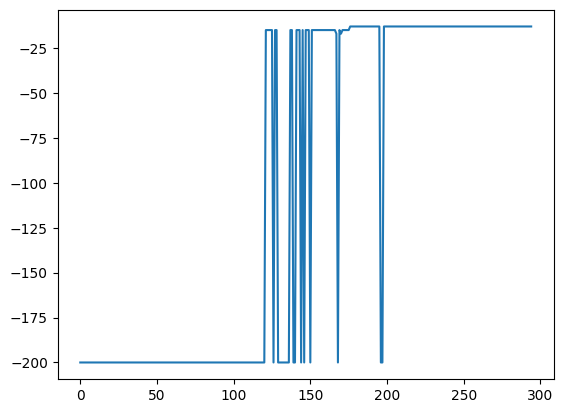

In [7]:
plt.plot(out[5:])

### Static/pretrain data

In [ ]:
# with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250408032240_withEps.pkl", 'rb') as file:
#     Qwen_7B_dataset = pickle.load(file)

# with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-32B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250408120007_withEps.pkl", 'rb') as file:
#     Qwen_32B_dataset = pickle.load(file)

# with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250407113942.pkl", 'rb') as file:
#     Qwen_7B_dataset = pickle.load(file)

# with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-32B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250407125034.pkl", 'rb') as file:
#     Qwen_32B_dataset = pickle.load(file)

# This is the CartPole-v0 llm data with 0.1 eps
with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250409023954E.pkl", 'rb') as file:
    Qwen_7B_dataset = pickle.load(file)

with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-32B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250409124533E.pkl", 'rb') as file:
    Qwen_32B_dataset = pickle.load(file)

Qwen_32B_rewards = []
for i in range(hyperparams["n_pretrain_eps"]):
    Qwen_32B_rewards.append(Qwen_32B_dataset.episodes[i].compute_return())
Qwen_7B_rewards = []
for i in range(hyperparams["n_pretrain_eps"]):
    Qwen_7B_rewards.append(Qwen_7B_dataset.episodes[i].compute_return())

Qwen_7B = Qwen_7B_rewards + hyperparams["n_online_eps"] * [np.mean(Qwen_7B_rewards)]
Qwen_32B = Qwen_32B_rewards + hyperparams["n_online_eps"] * [np.mean(Qwen_32B_rewards)]

print("Qwen_32B: ", np.mean(Qwen_7B_rewards))
print("Qwen_7B: ", np.mean(Qwen_32B_rewards))

### Generate and evaluate random baseline

In [ ]:
# Evaluate the random policy manually
random_rewards = []
for _ in range(hyperparams["n_pretrain_eps"]):
	obs, _ = env.reset()
	done = False
	total_reward = 0
	count = 0
	while not done:
		action = env.action_space.sample()
		obs, reward, done, _, _ = env.step(action)
		total_reward += reward
		count += 1
		if count >= hyperparams["max_episode_len"]:
			break
	random_rewards.append(total_reward)

mean_random = np.ones(hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]) * np.mean(random_rewards)
# Print the average reward of the random policy
print(f"Average reward for random policy: {mean_random[0]}")

### Fine-tune and Online data

In [ ]:
with open(f"data/cache_{hyperparams['env'].split('-')[0]}{hyperparams['n_pretrain_eps']}E.pkl", 'rb') as file:
    cache = pickle.load(file)

online_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
finetune_7b_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
finetune_32b_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
pretrain_7b_1000_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
pretrain_32b_1000_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
pretrain_7b_3000_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
pretrain_32b_3000_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))

for i in range(hyperparams["n_exp"]):
    online_returns[i] = cache[f"online_{i}"]
    for j in range(hyperparams["n_online_eps"]):
        finetune_7b_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"finetune_7b_{i}"][j]
        finetune_32b_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"finetune_32b_{i}"][j]
        pretrain_7b_1000_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"pretrain_7b_1000_{i}"][j]
        pretrain_32b_1000_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"pretrain_32b_1000_{i}"][j]
        pretrain_7b_3000_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"pretrain_7b_3000_{i}"][j]
        pretrain_32b_3000_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"pretrain_32b_3000_{i}"][j]

# Plot

In [ ]:
x = range(hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"])

mean_finetune_32b = np.mean(finetune_32b_returns, axis = 0)
std_finetune_32b = np.std(finetune_32b_returns, axis = 0)
mean_finetune_7b = np.mean(finetune_7b_returns, axis = 0)
std_finetune_7b = np.std(finetune_7b_returns, axis = 0)
mean_onl = np.mean(online_returns, axis = 0)
std_onl = np.std(online_returns, axis = 0)
mean_pretrain_32b_1000 = np.mean(pretrain_32b_1000_returns, axis = 0)
std_pretrain_32b_1000 = np.std(pretrain_32b_1000_returns, axis = 0)
mean_pretrain_7b_1000 = np.mean(pretrain_7b_1000_returns, axis = 0)
std_pretrain_7b_1000 = np.std(pretrain_7b_1000_returns, axis = 0)
mean_pretrain_32b_3000 = np.mean(pretrain_32b_3000_returns, axis = 0)
std_pretrain_32b_3000 = np.std(pretrain_32b_3000_returns, axis = 0)
mean_pretrain_7b_3000 = np.mean(pretrain_7b_3000_returns, axis = 0)
std_pretrain_7b_3000 = np.std(pretrain_7b_3000_returns, axis = 0)

mean_finetune_7b[:hyperparams["n_pretrain_eps"]] = Qwen_7B[:hyperparams["n_pretrain_eps"]]
mean_finetune_32b[:hyperparams["n_pretrain_eps"]] = Qwen_32B[:hyperparams["n_pretrain_eps"]]
mean_pretrain_32b_1000[:hyperparams["n_pretrain_eps"]] = Qwen_32B[:hyperparams["n_pretrain_eps"]]
mean_pretrain_7b_1000[:hyperparams["n_pretrain_eps"]] = Qwen_7B[:hyperparams["n_pretrain_eps"]]
mean_pretrain_32b_3000[:hyperparams["n_pretrain_eps"]] = Qwen_32B[:hyperparams["n_pretrain_eps"]]
mean_pretrain_7b_3000[:hyperparams["n_pretrain_eps"]] = Qwen_7B[:hyperparams["n_pretrain_eps"]]

plt.figure(figsize=(12, 6))
plt.plot(mean_onl, label='On-policy')
plt.fill_between(x, mean_onl-std_onl/np.sqrt(hyperparams["n_exp"]), mean_onl+std_onl/np.sqrt(hyperparams["n_exp"]), alpha=0.5)
plt.plot(mean_finetune_32b, label='Mix Qwen 32B')
plt.fill_between(x, mean_finetune_32b-std_finetune_32b/np.sqrt(hyperparams["n_exp"]), mean_finetune_32b+std_finetune_32b/np.sqrt(hyperparams["n_exp"]), alpha=0.5)
plt.plot(mean_finetune_7b, label='Mix Qwen 7B')
plt.fill_between(x, mean_finetune_7b-std_finetune_7b/np.sqrt(hyperparams["n_exp"]), mean_finetune_7b+std_finetune_7b/np.sqrt(hyperparams["n_exp"]), alpha=0.5)
plt.plot(mean_pretrain_32b_1000, label='Pretrain Qwen 32B 1000 steps')
plt.fill_between(x, mean_pretrain_32b_1000-std_pretrain_32b_1000/np.sqrt(hyperparams["n_exp"]), mean_pretrain_32b_1000+std_pretrain_32b_1000/np.sqrt(hyperparams["n_exp"]), alpha=0.5)
plt.plot(mean_pretrain_7b_1000, label='Pretrain Qwen 7B 1000 steps')
plt.fill_between(x, mean_pretrain_7b_1000-std_pretrain_7b_1000/np.sqrt(hyperparams["n_exp"]), mean_pretrain_7b_1000 +std_pretrain_7b_1000/np.sqrt(hyperparams["n_exp"]), alpha=0.5)
plt.plot(mean_pretrain_32b_3000, label='Pretrain Qwen 32B 3000 steps')
plt.fill_between(x, mean_pretrain_32b_3000-std_pretrain_32b_3000/np.sqrt(hyperparams["n_exp"]), mean_pretrain_32b_3000+std_pretrain_32b_3000/np.sqrt(hyperparams["n_exp"]), alpha=0.5)
plt.plot(mean_pretrain_7b_3000, label='Pretrain Qwen 7B 3000 steps')
plt.fill_between(x, mean_pretrain_7b_3000-std_pretrain_7b_3000/np.sqrt(hyperparams["n_exp"]), mean_pretrain_7b_3000 +std_pretrain_7b_3000/np.sqrt(hyperparams["n_exp"]), alpha=0.5)

plt.plot(Qwen_7B, label='Qwen_7B', linestyle=':')
plt.plot(Qwen_32B, label='Qwen_32B', linestyle=':')
plt.plot(mean_random, label='Random', linestyle=':')

# Customize the plot
plt.title(f'Sum episode reward for Double-DQN with {hyperparams["n_pretrain_eps"]} eps data collection and {hyperparams["n_online_eps"]} eps On-policy learning (#seed={hyperparams["n_exp"]}) with std error.')
plt.xlabel('# of episodes')
plt.ylabel('Eps reward')
# plt.legend()
# plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.xticks(np.arange(0, 101, 10))
# Show the plot
plt.show()

In [ ]:
# # Create the plot
# plt.figure(figsize=(10, 6))

# plt.plot(mean_onl, label='On-policy')
# plt.fill_between(x, mean_onl-std_onl, mean_onl+std_onl, alpha=0.5)
# plt.plot(mean_finetune_32b, label='Mix Qwen 32B')
# plt.fill_between(x, mean_finetune_32b-std_finetune_32b, mean_finetune_32b+std_finetune_32b, alpha=0.5)
# plt.plot(mean_finetune_7b, label='Mix Qwen 7B')
# plt.fill_between(x, mean_finetune_7b-std_finetune_7b, mean_finetune_7b+std_finetune_7b, alpha=0.5)
# plt.plot(mean_pretrain_32b_1000, label='Pretrain Qwen 32B 1000 steps')
# plt.fill_between(x, mean_pretrain_32b_1000-std_pretrain_32b_1000, mean_pretrain_32b_1000+std_pretrain_32b_1000, alpha=0.5)
# plt.plot(mean_pretrain_7b_1000, label='Pretrain Qwen 7B 1000 steps')
# plt.fill_between(x, mean_pretrain_7b_1000-std_pretrain_7b_1000, mean_pretrain_7b_1000 +std_pretrain_7b_1000, alpha=0.5)
# plt.plot(mean_pretrain_32b_3000, label='Pretrain Qwen 32B 3000 steps')
# plt.fill_between(x, mean_pretrain_32b_3000-std_pretrain_32b_3000, mean_pretrain_32b_3000+std_pretrain_32b_3000, alpha=0.5)
# plt.plot(mean_pretrain_7b_3000, label='Pretrain Qwen 7B 3000 steps')
# plt.fill_between(x, mean_pretrain_7b_3000-std_pretrain_7b_3000, mean_pretrain_7b_3000 +std_pretrain_7b_3000, alpha=0.5)

# plt.plot(Qwen_7B, label='Qwen_7B', linestyle=':')
# plt.plot(Qwen_32B, label='Qwen_32B', linestyle=':')
# plt.plot(mean_random, label='Random', linestyle=':')

# # Customize the plot
# plt.title(f'Sum episode reward for Double-DQN with {hyperparams["n_pretrain_eps"]} eps data collection and {hyperparams["n_online_eps"]} eps On-policy learning (#seed={hyperparams["n_exp"]})')
# plt.xlabel('# of episodes')
# plt.ylabel('Eps reward')
# # plt.legend()
# # plt.grid(True)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# # plt.xticks(np.arange(0, 101, 10))

# # Show the plot
# plt.show()

In [ ]:
# def moving_average(data, window_size):
#     """Compute moving average using convolution."""
#     window = np.ones(window_size) / window_size
#     # return np.convolve(data, window, mode='valid')
#     half_window = window_size // 2
#     new_data = np.pad(data, (half_window, half_window), mode='reflect')  # Pad data to handle edges
#     return np.convolve(new_data, window, mode='valid')

# # Define the window size for smoothing
# window_size = 5  # Adjust this value as needed

# # Smooth the data
# smoothed_mean_onl = moving_average(mean_onl, window_size)
# smoothed_mean_finetune_32b = moving_average(mean_finetune_32b, window_size)
# smoothed_mean_finetune_7b = moving_average(mean_finetune_7b, window_size)
# smoothed_mean_pretrain_32b_1000 = moving_average(mean_pretrain_32b_1000, window_size)
# smoothed_mean_pretrain_7b_1000 = moving_average(mean_pretrain_7b_1000, window_size)
# smoothed_mean_pretrain_32b_3000 = moving_average(mean_pretrain_32b_3000, window_size)
# smoothed_mean_pretrain_7b_3000 = moving_average(mean_pretrain_7b_3000, window_size)

# # Adjust the x-axis range for the smoothed data
# x_smooth = range(len(smoothed_mean_onl))

# # Plot the smoothed results
# plt.figure(figsize=(10, 6))

# plt.plot(x_smooth, smoothed_mean_onl, label='Smoothed On-policy')
# plt.fill_between(x, smoothed_mean_onl-std_onl, smoothed_mean_onl+std_onl, alpha=0.5)
# plt.plot(x_smooth, smoothed_mean_finetune_32b, label='Smoothed Mix Qwen 32B')
# plt.fill_between(x, smoothed_mean_finetune_32b-std_finetune_32b, smoothed_mean_finetune_32b+std_finetune_32b, alpha=0.5)
# plt.plot(x_smooth, smoothed_mean_finetune_7b, label='Smoothed Mix Qwen 7B')
# plt.fill_between(x, smoothed_mean_finetune_7b-std_finetune_7b, smoothed_mean_finetune_7b+std_finetune_7b, alpha=0.5)
# plt.plot(smoothed_mean_pretrain_32b_1000, label='Smoothed Pretrain Qwen 32B 1000 steps')
# plt.fill_between(x, smoothed_mean_pretrain_32b_1000-std_pretrain_32b_1000, smoothed_mean_pretrain_32b_1000+std_pretrain_32b_1000, alpha=0.5)
# plt.plot(smoothed_mean_pretrain_7b_1000, label='Smoothed Pretrain Qwen 7B 1000 steps')
# plt.fill_between(x, smoothed_mean_pretrain_7b_1000-std_pretrain_7b_1000, smoothed_mean_pretrain_7b_1000 +std_pretrain_7b_1000, alpha=0.5)
# plt.plot(smoothed_mean_pretrain_32b_3000, label='Smoothed Pretrain Qwen 32B 3000 steps')
# plt.fill_between(x, smoothed_mean_pretrain_32b_3000-std_pretrain_32b_3000, smoothed_mean_pretrain_32b_3000+std_pretrain_32b_3000, alpha=0.5)
# plt.plot(smoothed_mean_pretrain_7b_3000, label='Smoothed Pretrain Qwen 7B 3000 steps')
# plt.fill_between(x, smoothed_mean_pretrain_7b_3000-std_pretrain_7b_3000, smoothed_mean_pretrain_7b_3000 +std_pretrain_7b_3000, alpha=0.5)

# plt.plot(Qwen_7B, label='Qwen_7B', linestyle=':')
# plt.plot(Qwen_32B, label='Qwen_32B', linestyle=':')
# plt.plot(mean_random, label='Random', linestyle=':')

# # Customize the plot
# plt.title(f'Smoothed sum episode reward for Double-DQN with {hyperparams["n_pretrain_eps"]} eps data collection and {hyperparams["n_online_eps"]} eps On-policy learning (#seed={hyperparams["n_exp"]})')
# plt.xlabel('# of episodes')
# plt.ylabel('Eps reward')
# # plt.grid(True)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# # plt.xticks(np.arange(0, 101, 10))
# # plt.legend()
# # plt.grid(True)

# # Show the plot
# plt.show()
